# Statoil/C-CORE Iceberg Classifier Challenge
* * *

## Ship or iceberg, can you decide from space?


## 목차
- 개요
- Background 간략 설명
- 사전작업
- 데이터 설명
- 데이터 분석
- 접근법
- 모델

## 개요

> 떠내려오는 빙상은 항해와 활동에 위협이 된다. 현재에는 항공 정찰과 해안 기반 지원을 통하여 환경 상황(빙상)을 감시할 수 있지만 날씨가 험한 오지에서는 위와 같은 방법들은 사용할 수 없으며, 유일한 방법은 위성을 통한 감시 뿐이다. <br><br>
국제 에너지 회사인 Statoil은 가능한 한 빨리 빙산을 더 정확하게 탐지하고 차별하기 위해 기계 학습을 사용하는 방법에 대한 새로운 관점을 얻는 데 관심이 있다. <br><br>
이 Competition 에서는 배인지 빙산인지 자동으로 식별하는 알고리즘을 구축해야 한다. =

## Background 간략 설명

Sentinel-1 위성은 육지와 바다를 감시하는데 사용된다. 이 위성은 어둠, 비, 그림, 안개를 볼 수 있어서 밤낮으로 이미지를 캡처할 수 있다.
물체가 주변보다 더 많은 레이더 에너지를 반사하기 때문에 밝은 지점으로 나타나지만 주변 장애물에서도 많은 레이더 에너지가 나올 수 있다. <br><br>

레이더가 물체를 감지할 때, 반사되는 에너지를 백스캐터라 하는데 이 것만으로는 빙산을 구별할 수 없다. 그러므로 모양, 크기, 밝기 등 특정한 특징들을 더욱 분석해야할 필요가 있다. 이 경우, 물체를 둘러싼 영역을 분석하거나 모델링할 수 있다.

많은 것들이 백스캐터에 영향을 끼친다. 강풍은 밝은 배경을 만들어 내고 반대는 어두운 배경을 만든다.

Sentinel-1 위성은 side looking rader로 이미지 영역을 각도(incidence angle: 입사각)로 보는 것을 의미한다.

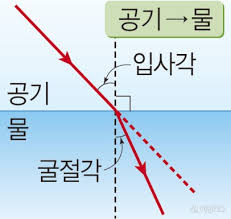

일반적으로, 해양 배경은 더 높은 발생 각도에서 더 어두워질 것이다. Sentinel-1은 수평면과 수직면에서 송신하고 수신할 수 있으며, 이것은 dual-polarization(이중극화) 이미지를 얻을 수 있다.

이 대회에서 HH와 HV의 채널을 볼 수 있으며, 두 채널은 객체의 특성에 중요한 역할을 할 수 있다.
![iceberg](https://storage.googleapis.com/kaggle-media/competitions/statoil/8ZkRcp4.png) 
![ship](https://storage.googleapis.com/kaggle-media/competitions/statoil/M8OP2F2.png)

## 사전 작업

In [1]:
import os

In [2]:
cur_path = os.getcwd()

In [3]:
file_path = '/kaggle/statoil-iceberg-classifier-challenge'

In [4]:
cur_path + file_path

'/home/gunmo/git/jupyters/kaggle/statoil-iceberg-classifier-challenge'

## 데이터 설명

In [5]:
!ls ./

 Lets_try_the_functools.ipynb
 Lets_try_the_itertools.ipynb
 Lets_try_the_operator.ipynb
'[KAGGLE]Statoil_C-CORE Iceberg Classifier Challenge.ipynb'
 classmethod와staticmethod.ipynb
 kaggle
 matplotlib_Introductory.ipynb
'python magic_method.ipynb'
 stinkbug.png


In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [7]:
train = pd.read_json(cur_path + file_path + '/train.json')
test = pd.read_json(cur_path + file_path + '/test.json')
sample = pd.read_csv(cur_path + file_path + '/sample_submission.csv')

In [165]:
print(train.keys())
print(test.keys())

Index(['id', 'band_1', 'band_2', 'inc_angle', 'is_iceberg'], dtype='object')
Index(['id', 'band_1', 'band_2', 'inc_angle'], dtype='object')


id : PK <br>
band_1 : HH <br>
band_2 : HB <br>
inc_angle : inc_angle <br>
is_iceberg, int, [0, 1]

In [9]:
sample.head(4)

,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5


## 데이터 분석

In [10]:
X_band_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_1"]])
X_band_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train["band_2"]])
X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], axis=-1)

In [11]:
X_band_1.shape, X_band_2.shape, X_train.shape

((1604, 75, 75), (1604, 75, 75), (1604, 75, 75, 3))

In [12]:
raw_data = X_train.copy()

In [13]:
def normalize(d):
    # d is a (n x dimension) np array
    d -= np.mean (d, axis=0)
    d /= np.std(d, axis=0)
    return d
normalize_data = normalize(X_train.copy())

In [14]:
def normal_image(d):
    # d is a (n x dimension) np array
    d -= np.min(d, axis=0)
    d /= np.ptp(d, axis=0)
    return d

In [15]:
temp = X_train.copy() 
normalize_all_data =  (temp - np.mean(temp)) / np.std(temp)

In [16]:
normalize_data.max(), normalize_data.min(), normalize_all_data.max(), normalize_all_data.min()

(12.673096, -6.6953144, 12.091329, -4.616211)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


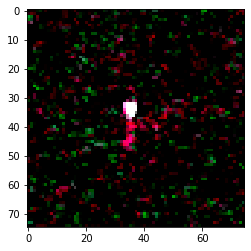

In [17]:
plt.imshow(normalize_all_data[4])

In [100]:
normal_img_data = normal_image(X_train.copy())

(<matplotlib.image.AxesImage at 0x7f0d56597048>, 1)

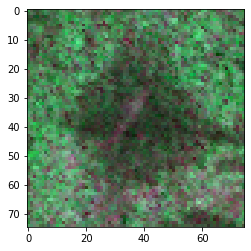

In [19]:
idx = 6
plt.imshow(normal_img_data[idx]), train['is_iceberg'][idx]

In [144]:
check = np.tile(train['is_iceberg'].to_numpy(),4)

In [153]:
check.shape[0] // 4

1604

In [79]:
noise_data = normal_img_data.copy() * np.random.normal(0, 1, size = X_train.shape)
noise_data_2 = normal_img_data.copy() * np.random.normal(0, 0.6, size = X_train.shape)
noise_data_3 = normal_img_data.copy() * np.random.normal(0, 0.2, size = X_train.shape)

In [80]:
noise_data_4 = normalize_all_data.copy() + np.random.normal(0, 1, size = X_train.shape)
noise_data_5 = normalize_all_data.copy() + np.random.normal(0, 0.6, size = X_train.shape)
noise_data_6 = normalize_all_data.copy() + np.random.normal(0, 0.2, size = X_train.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


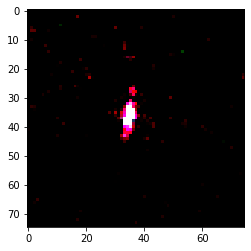

In [86]:
plt.imshow(noise_data_6[0])

In [59]:
def imshow(data):
    data -= np.min(data, axis = 0)
    data /= np.ptp(data, axis = 0)
    print(data.shape)
    print(data.max(), data.min())
    plt.imshow(data * 255)

In [93]:
def rotate90(X_DATA):
    for i in range(len(X_DATA)):
        X_DATA[i] = np.rot90(X_DATA[i])
    return X_DATA

In [102]:
normal_img_rot_data_1 = rotate90(normal_img_data.copy())
normal_img_rot_data_2 = rotate90(normal_img_rot_data_1.copy())
normal_img_rot_data_3 = rotate90(normal_img_rot_data_2.copy())

In [122]:
normalize_rot_data_1 = rotate90(normalize_all_data.copy())
normalize_rot_data_2 = rotate90(normalize_rot_data_1.copy())
normalize_rot_data_3 = rotate90(normalize_rot_data_2.copy())

In [123]:
aa = np.concatenate((normalize_all_data, normalize_rot_data_1), axis = 0)
aa = np.concatenate((aa, normalize_rot_data_2), axis = 0)
normalize_rot_data = np.concatenate((aa, normalize_rot_data_3), axis = 0)

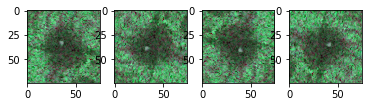

In [107]:
idx = 4
plt.subplot(1, 4, 1)
plt.imshow(normal_img_data[idx])
plt.subplot(1, 4, 2)
plt.imshow(normal_img_rot_data_1[idx])
plt.subplot(1, 4, 3)
plt.imshow(normal_img_rot_data_2[idx])
plt.subplot(1, 4, 4)
plt.imshow(normal_img_rot_data_3[idx])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 0, '1')

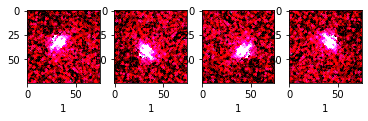

In [160]:
idx = 5
plt.subplot(1, 4, 1)
plt.imshow(normalize_all_data[idx])
plt.xlabel(check[idx])
plt.subplot(1, 4, 2)
plt.imshow(normalize_rot_data_1[idx])
plt.xlabel(check[idx + 1604])
plt.subplot(1, 4, 3)
plt.imshow(normalize_rot_data_2[idx])
plt.xlabel(check[idx + 3208])
plt.subplot(1, 4, 4)
plt.imshow(normalize_rot_data_3[idx])
plt.xlabel(check[idx + 4812])

In [114]:
aa = np.concatenate((normal_img_data, normal_img_rot_data_1), axis = 0)
aa = np.concatenate((aa, normal_img_rot_data_2), axis = 0)
normal_img_rot_data = np.concatenate((aa, normal_img_rot_data_3), axis = 0)

In [116]:
normal_img_rot_data.shape, check.shape

((6416, 75, 75, 3), (6416,))

In [161]:
shuf = np.arange(normal_img_rot_data.shape[0])
np.random.shuffle(shuf)
normal_img_rot_data = normal_img_rot_data[shuf]
normal_img_check = check.copy()[shuf]

In [162]:
shuf = np.arange(normalize_rot_data.shape[0])
np.random.shuffle(shuf)
normalize_rot_data = normalize_rot_data[shuf]
normalize_check = check.copy()[shuf]

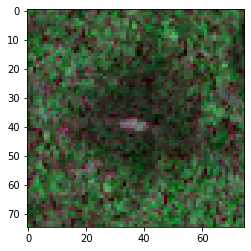

In [113]:
plt.imshow(aa[1604])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(75, 75, 3)
1.0 0.0


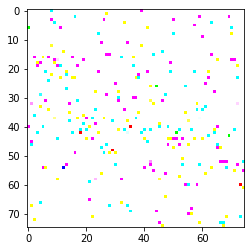

In [60]:
imshow(noise_data[3].copy())

In [70]:
train["id"].head() # string 값

0    dfd5f913
1    e25388fd
2    58b2aaa0
3    4cfc3a18
4    271f93f4
Name: id, dtype: object

In [17]:
len(set(train['inc_angle'].to_list()))

879

In [18]:
sum(train['is_iceberg'] == 1), sum(train['is_iceberg'] == 0) # iceberg: 753, ship: 851

(753, 851)

In [19]:
np.max(X_train[1])
# plt.imshow(X_train[0])

12.570409

## 접근법

- normalize
- rotate
- noise

## 모델

In [61]:
#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
import tensorflow as tf
from keras import backend as  K

config = tf.ConfigProto(
allow_soft_placement=True, log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

Using TensorFlow backend.
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gunmo/anaconda3/envs/yolov3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gunmo/anaconda3/e

In [135]:
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    # gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
model_path = cur_path + file_path + "/model_weights.hdf5"
callbacks = get_callbacks(filepath=model_path, patience=5)

In [136]:
target_train = train['is_iceberg']
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, target_train, random_state = 1, train_size = 0.75)

In [141]:
def train_base_helper(X_DATA, target_train = train['is_iceberg']):
    callbacks = get_callbacks(filepath=model_path, patience=5)
    X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_DATA, target_train, random_state = 1, train_size = 0.8)
    gmodel = getModel()
    gmodel.fit(X_train_cv, y_train_cv,
          batch_size=6,
          epochs=100,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)
    loss, acc = gmodel.evaluate(X_valid, y_valid)
    print("모델의 정확도: {:5.2f}%".format(100*acc))

In [166]:
import os
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=12,
          epochs=100,
          verbose=0,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)
loss, acc = gmodel.evaluate(X_valid, y_valid)
print("모델의 정확도: {:5.2f}%".format(100*acc))

401/401 [==============================] - 0s 239us/step
모델의 정확도: 88.03%


In [169]:
train_base_helper(normalize_data)

401/401 [==============================] - 0s 253us/step
모델의 정확도: 86.78%


In [142]:
train_base_helper(normalize_all_data)

Train on 1283 samples, validate on 321 samples
Epoch 1/100
1283/1283 [==============================] - 7s 5ms/step - loss: 0.6557 - acc: 0.5573 - val_loss: 0.6475 - val_acc: 0.6511
Epoch 2/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.5921 - acc: 0.6555 - val_loss: 0.5503 - val_acc: 0.7601
Epoch 3/100
1283/1283 [==============================] - 2s 2ms/step - loss: 0.5242 - acc: 0.7132 - val_loss: 0.4573 - val_acc: 0.8193
Epoch 4/100
1283/1283 [==============================] - 2s 1ms/step - loss: 0.4700 - acc: 0.7584 - val_loss: 0.3995 - val_acc: 0.8349
Epoch 5/100
1283/1283 [==============================] - 2s 1ms/step - loss: 0.4151 - acc: 0.8075 - val_loss: 0.3585 - val_acc: 0.8692
Epoch 6/100
1283/1283 [==============================] - 2s 1ms/step - loss: 0.3683 - acc: 0.8239 - val_loss: 0.3164 - val_acc: 0.8847
Epoch 7/100
1283/1283 [==============================] - 2s 1ms/step - loss: 0.3481 - acc: 0.8542 - val_loss: 0.3114 - val_acc: 0.8910
Epoch 8/

In [171]:
train_base_helper(normal_img_data)

401/401 [==============================] - 0s 240us/step
모델의 정확도: 88.28%


In [87]:
train_base_helper(noise_data) # normal_img_data

401/401 [==============================] - 0s 283us/step
모델의 정확도: 73.07%


In [88]:
train_base_helper(noise_data_2)

401/401 [==============================] - 0s 228us/step
모델의 정확도: 73.32%


In [89]:
train_base_helper(noise_data_3)

401/401 [==============================] - 0s 277us/step
모델의 정확도: 68.08%


In [90]:
train_base_helper(noise_data_4) # noramlize_all_data noise

401/401 [==============================] - 0s 279us/step
모델의 정확도: 85.79%


In [91]:
train_base_helper(noise_data_5)

401/401 [==============================] - 0s 173us/step
모델의 정확도: 83.79%


In [92]:
train_base_helper(noise_data_6)

401/401 [==============================] - 0s 232us/step
모델의 정확도: 87.03%


In [163]:
train_base_helper(normal_img_rot_data, target_train=normal_img_check)

Train on 5132 samples, validate on 1284 samples
Epoch 1/100
5132/5132 [==============================] - 15s 3ms/step - loss: 0.6932 - acc: 0.5261 - val_loss: 0.6918 - val_acc: 0.5296
Epoch 2/100
5132/5132 [==============================] - 9s 2ms/step - loss: 0.6922 - acc: 0.5308 - val_loss: 0.6915 - val_acc: 0.5296
Epoch 3/100
5132/5132 [==============================] - 8s 2ms/step - loss: 0.6920 - acc: 0.5308 - val_loss: 0.6916 - val_acc: 0.5296
Epoch 4/100
5132/5132 [==============================] - 8s 2ms/step - loss: 0.6916 - acc: 0.5308 - val_loss: 0.6914 - val_acc: 0.5296
Epoch 5/100
5132/5132 [==============================] - 7s 1ms/step - loss: 0.6915 - acc: 0.5281 - val_loss: 0.6922 - val_acc: 0.5296
Epoch 6/100
5132/5132 [==============================] - 7s 1ms/step - loss: 0.6915 - acc: 0.5308 - val_loss: 0.6914 - val_acc: 0.5296
Epoch 7/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6916 - acc: 0.5308 - val_loss: 0.6914 - val_acc: 0.5296
Epoch 

In [164]:
train_base_helper(normalize_rot_data, target_train=normalize_check)

Train on 5132 samples, validate on 1284 samples
Epoch 1/100
5132/5132 [==============================] - 11s 2ms/step - loss: 0.6983 - acc: 0.5117 - val_loss: 0.6916 - val_acc: 0.5358
Epoch 2/100
5132/5132 [==============================] - 7s 1ms/step - loss: 0.6938 - acc: 0.5150 - val_loss: 0.6929 - val_acc: 0.5187
Epoch 3/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6933 - acc: 0.5216 - val_loss: 0.6912 - val_acc: 0.5358
Epoch 4/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6921 - acc: 0.5236 - val_loss: 0.6915 - val_acc: 0.5358
Epoch 5/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6922 - acc: 0.5222 - val_loss: 0.6912 - val_acc: 0.5358
Epoch 6/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6919 - acc: 0.5253 - val_loss: 0.6910 - val_acc: 0.5358
Epoch 7/100
5132/5132 [==============================] - 6s 1ms/step - loss: 0.6922 - acc: 0.5279 - val_loss: 0.6910 - val_acc: 0.5358
Epoch 

In [193]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    rotation_range=350,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range = 0.3,
    horizontal_flip=True,
    vertical_flip= True
)

In [194]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(normalize_all_data, target_train, random_state = 1, train_size = 0.75)
datagen.fit(X_train_cv)

In [198]:
model_gen = getModel()
model_gen.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size = 12),
        steps_per_epoch=len(X_train),
        epochs = 100,
        verbose=1,
        validation_data=(X_valid, y_valid),
        callbacks = callbacks
)

Epoch 1/100
1604/1604 [==============================] - 23s 15ms/step - loss: 0.5565 - acc: 0.6873 - val_loss: 0.4757 - val_acc: 0.7880
Epoch 2/100
1604/1604 [==============================] - 17s 11ms/step - loss: 0.4199 - acc: 0.8025 - val_loss: 0.6392 - val_acc: 0.6584
Epoch 3/100
1604/1604 [==============================] - 17s 11ms/step - loss: 0.3728 - acc: 0.8282 - val_loss: 0.5044 - val_acc: 0.7880
Epoch 4/100
1604/1604 [==============================] - 17s 11ms/step - loss: 0.3417 - acc: 0.8450 - val_loss: 0.7398 - val_acc: 0.6284
Epoch 5/100
1604/1604 [==============================] - 17s 11ms/step - loss: 0.3213 - acc: 0.8565 - val_loss: 0.6332 - val_acc: 0.7057
Epoch 6/100
1604/1604 [==============================] - 17s 11ms/step - loss: 0.3104 - acc: 0.8618 - val_loss: 0.7019 - val_acc: 0.6958


In [189]:
loss, acc = model_gen.evaluate(X_valid, y_valid)
print("모델의 정확도: {:5.2f}%".format(100*acc))

401/401 [==============================] - 0s 136us/step
모델의 정확도: 65.84%


In [202]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip= True
)

In [203]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(raw_data, target_train, random_state = 1, train_size = 0.75)
datagen.fit(X_train_cv)

In [204]:
model_gen = getModel()
model_gen.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size = 12),
        steps_per_epoch=len(X_train),
        epochs = 100,
        verbose=1,
        validation_data=(X_valid, y_valid),
        callbacks = callbacks
)
loss, acc = model_gen.evaluate(X_valid, y_valid)
print("모델의 정확도: {:5.2f}%".format(100*acc))

Epoch 1/100
1604/1604 [==============================] - 23s 14ms/step - loss: 0.5014 - acc: 0.7264 - val_loss: 1.8192 - val_acc: 0.5112
Epoch 2/100
1604/1604 [==============================] - 16s 10ms/step - loss: 0.3625 - acc: 0.8321 - val_loss: 7.5548 - val_acc: 0.5312
Epoch 3/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.3321 - acc: 0.8517 - val_loss: 7.5566 - val_acc: 0.5312
Epoch 4/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.3062 - acc: 0.8624 - val_loss: 7.5566 - val_acc: 0.5312
Epoch 5/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.2942 - acc: 0.8709 - val_loss: 7.5566 - val_acc: 0.5312
Epoch 6/100
401/401 [==============================] - 0s 130us/step
모델의 정확도: 53.12%


In [205]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip= True
)

In [206]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(normal_img_data, target_train, random_state = 1, train_size = 0.75)
datagen.fit(X_train_cv)

In [207]:
model_gen = getModel()
model_gen.fit_generator(datagen.flow(X_train_cv, y_train_cv, batch_size = 12),
        steps_per_epoch=len(X_train),
        epochs = 100,
        verbose=1,
        validation_data=(X_valid, y_valid),
        callbacks = callbacks
)
loss, acc = model_gen.evaluate(X_valid, y_valid)
print("모델의 정확도: {:5.2f}%".format(100*acc))

Epoch 1/100
1604/1604 [==============================] - 23s 14ms/step - loss: 0.5420 - acc: 0.6918 - val_loss: 0.6818 - val_acc: 0.5461
Epoch 2/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.4102 - acc: 0.8076 - val_loss: 0.8502 - val_acc: 0.4688
Epoch 3/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.3732 - acc: 0.8301 - val_loss: 1.0489 - val_acc: 0.4688
Epoch 4/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.3482 - acc: 0.8421 - val_loss: 1.3107 - val_acc: 0.4688
Epoch 5/100
1604/1604 [==============================] - 17s 10ms/step - loss: 0.3313 - acc: 0.8522 - val_loss: 1.4491 - val_acc: 0.4688
Epoch 6/100
401/401 [==============================] - 0s 130us/step
모델의 정확도: 46.88%
